## Import Modules

In [10]:
import os, re, glob, cv2, csv
import numpy as np
import cupy as cp
from cupyx.scipy import ndimage as cpx_ndimage  # Import CuPy's GPU ndimage module
import tifffile as tiff
import scipy as sp
from scipy import ndimage, io as sio
from scipy.ndimage import maximum_filter, label, find_objects
from scipy.stats import chi2, lognorm, poisson, norm
from scipy.optimize import curve_fit
from skimage.feature import peak_local_max
from natsort import natsorted
import trackpy as tp
import pandas as pd
import multiprocessing as mp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
from matplotlib.widgets import Slider
from matplotlib import animation, rc
import matplotlib.colors as mcolors
from tqdm import tqdm
from IPython.display import display, Image

# Set up matplotlib for animations
rc('animation', html='jshtml')

# Suppress specific warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # ignore warnings for specific matplotlib commands which will be outdated soon


## Define functions

In [2]:
def convert_to_code_path(windows_path):
    """
    Converts a Windows file path with single backslashes to a format with double backslashes for use in Python code.

    Parameters:
    - windows_path: str
        The original Windows file path (e.g., 'C:\\Users\\YourName\\Folder').

    Returns:
    - str
        The modified path with double backslashes, suitable for Python (e.g., 'C:\\\\Users\\\\YourName\\\\Folder').
    """
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")



def mask_size(data_folder, resolution):
    """
    Calculate the number of non-NaN pixels in a neural mask.

    Parameters:
    - data_folder (str): Path to the folder containing the 'neural_mask.mat' file.
    - resolution (float): Resolution to scale the pixel count (e.g., micrometers per pixel).

    Returns:
    - float: Number of non-NaN pixels scaled by the given resolution.
    """
    # Load the neural mask from the specified path
    mask_path = os.path.join(data_folder, 'neural_mask.mat')
    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"Mask file not found at: {mask_path}")
    
    mask = sio.loadmat(mask_path)['neural_mask']
    
    # Convert the mask to float and replace 0s with NaN
    mask = mask.astype(float)
    mask[mask == 0] = np.NaN
    
    # Count the number of non-NaN pixels
    non_nan_pixels = np.count_nonzero(~np.isnan(mask))
    
    # Scale the result based on resolution
    scaled_size = non_nan_pixels / (resolution ** 2)
    
    return scaled_size


def track_metrics_and_opflow(data_folder, time_interval):
    """
    Calculate the number of data rows/tracks in 'track_metrics.csv' (excluding the header), 
    and the total duration of the movie based on the number of files in the 'Op_flow' folder.

    Parameters:
    - data_folder (str): Path to the folder containing 'track_metrics.csv' and 'Op_flow' folder.
    - time_interval (float): Time interval (in seconds, minutes, etc.) between frames for that movie.

    Returns:
    - tuple: 
        - int: Number of data rows or tracks in 'track_metrics.csv' (excluding the header).
        - float: Total time calculated as `num_files * time_interval`.
    
    Raises:
    - FileNotFoundError: If the 'track_metrics.csv' file or 'Op_flow' folder is not found.
    - ValueError: If there is an error reading 'track_metrics.csv'.
    """
    # Path to the 'track_metrics.csv' file
    metrics_path = os.path.join(data_folder, 'track_metrics.csv')
    if not os.path.exists(metrics_path):
        raise FileNotFoundError(f"'track_metrics.csv' file not found at: {metrics_path}")
    
    # Load the CSV and count rows
    try:
        track_metrics = pd.read_csv(metrics_path)
        num_rows = len(track_metrics)
    except Exception as e:
        raise ValueError(f"Error reading 'track_metrics.csv': {e}")
    
    # Subtract one if the header is present
    num_data_rows = num_rows - 1 if not track_metrics.empty else 0
    
    # Path to the 'Op_flow' folder
    opflow_folder = os.path.join(data_folder, 'Op_flow')
    if not os.path.exists(opflow_folder):
        raise FileNotFoundError(f"'Op_flow' folder not found at: {opflow_folder}")
    
    # Count the number of files in the 'Op_flow' folder
    num_files = len([f for f in os.listdir(opflow_folder) if os.path.isfile(os.path.join(opflow_folder, f))])

    # Calculate total time
    total_time = num_files * time_interval
    
    return num_data_rows, total_time




def extract_numeric(value):
    """
    Extracts numeric value from a given input. If the input is not numeric,
    it will return None.

    Args:
    - value: The input value to be processed.

    Returns:
    - float or None: The extracted numeric value, or None if the input is not valid.
    """
    # Convert to string and strip any leading/trailing whitespace
    value_str = str(value).strip()

    # Use regex to find numeric values (including decimals)
    match = re.findall(r"[-+]?\d*\.\d+|\d+", value_str)

    if match:
        return float(match[0])  # Return the first found numeric value
    else:
        return None

def get_file_names_and_params_by_div(sheet_path, div_value, sheet_name):
    """
    Get all 'file name', 'resolution', and 'frame interval' values from the specified Excel sheet where div 
    equals the given value.

    Args:
    - sheet_path (str): Path to the Excel sheet containing imaging details.
    - div_value (int): The 'div' value to filter the Excel sheet.
    - sheet_name (str): The sheet name in the Excel file.

    Returns:
    - params (list): A list of tuples containing ('file name', 'resolution', 'frame interval') where div equals div_value.
    """
    # Load the Excel sheet
    df_sheet = pd.read_excel(sheet_path, sheet_name=sheet_name)

    # Filter based on the 'div' value
    df_sheet_filtered = df_sheet[df_sheet['div'] == div_value]

    # Extract the parameters
    params = []
    for index in df_sheet_filtered.index:
        # Extract file name
        file_name = df_sheet_filtered['file name'][index]

        # Extract frame interval
        interval = df_sheet_filtered['frame interval'][index]
        integer_interval_value = extract_numeric(interval)

        # Extract resolution
        resolution = df_sheet_filtered['resolution'][index]
        integer_resolution_value = extract_numeric(resolution)

        # Append to params
        params.append((file_name, integer_resolution_value, integer_interval_value))

    return params




# def check_level_2_subfolders_by_div_and_params(
#     main_folder, sheet_path, div_value, sheet_name, resolution_range, frame_interval_range):
#     """
#     Check all level-2 subfolders under level-1 subfolders that match the specified div value,
#     and verify if their corresponding resolution and frame interval match the given criteria.
#     For matching subfolders, calculate mask sizes, track counts, and movie durations.

#     Args:
#     - main_folder (str): Path to the main folder containing level-1 subfolders.
#     - sheet_path (str): Path to the Excel sheet containing imaging details.
#     - div_value (int): The 'div' value to filter the Excel sheet (e.g., 2, 3, etc.).
#     - sheet_name (str): The name of the sheet in the Excel file to extract data from.
#     - resolution_range (tuple, optional): Minimum and maximum allowed resolution values (e.g., (2.6, 2.9)).
#     - frame_interval_range (tuple, optional): Minimum and maximum allowed frame interval values (e.g., (1.8, 2.2)).

#     Returns:
#     - tuple: A tuple containing three lists:
#         1. List of mask sizes for the matching subfolders.
#         2. List of track counts for the matching subfolders.
#         3. List of movie durations for the matching subfolders.

#     Raises:
#     - FileNotFoundError: If a required file or folder is missing.
#     - ValueError: If the input parameters are invalid or no matching subfolders are found.
#     """
#     # Retrieve parameters (file names, resolution, frame interval) from the Excel sheet for the given div value
#     params = get_file_names_and_params_by_div(sheet_path, div_value, sheet_name)
#     if not params:
#         print(f"No parameters found for div = {div_value}.")
#         return [], [], []

#     level_1_subfolder_name = f"div{div_value}"
#     mask_sizes = []
#     movie_duration = []
#     n_tracks = []

#     for subfolder in os.listdir(main_folder):
#         subfolder_path = os.path.join(main_folder, subfolder)
#         if os.path.isdir(subfolder_path) and subfolder == level_1_subfolder_name:
#             for level_2_subfolder in os.listdir(subfolder_path):
#                 level_2_subfolder_path = os.path.join(subfolder_path, level_2_subfolder)

#                 if os.path.isdir(level_2_subfolder_path):
#                     for file_name, resolution, frame_interval in params:
#                         if file_name in level_2_subfolder:
#                             print(f"Analyzing Level-2 Subfolder: {level_2_subfolder}")

#                             # Check if resolution and frame interval match the given criteria
#                             if ((resolution_range is None or (resolution is not None and 
#                                                               resolution_range[0] <= resolution <= resolution_range[1])) and
#                                 (frame_interval_range is None or (frame_interval is not None and 
#                                                                   frame_interval_range[0] <= frame_interval <= frame_interval_range[1]))):
#                                 print("Criteria Met")

#                                 # Look for the required file
#                                 found_file = next(
#                                     (file for file in os.listdir(level_2_subfolder_path)
#                                      if file.endswith('_jttr_blch_corr.tiff')), None)

#                                 if found_file:
#                                     folder_path = convert_to_code_path(
#                                         os.path.join(subfolder_path, level_2_subfolder))
#                                     try:
#                                         size = mask_size(folder_path, resolution)
#                                         mask_sizes.append(size)
#                                         print(f"Mask size added: {size}")

#                                         num_tracks, duration = track_metrics_and_opflow(folder_path, frame_interval)
#                                         n_tracks.append(num_tracks)
#                                         movie_duration.append(duration)
#                                         print(f"Movie duration added: {duration}(s)")
#                                         print(f"Number of tracks added: {num_tracks}")
                                    
#                                     except Exception as e:
#                                         print(f"Error in {level_2_subfolder}: {e}")
#                                 else:
#                                     print("No '_jttr_blch_corr.tiff' file found.")
#                             else:
#                                 print("Criteria Not Met")

#     return mask_sizes, n_tracks, movie_duration


def check_level_2_subfolders_by_div_and_params(
    main_folder, sheet_path, div_value, sheet_name, resolution_range, frame_interval_range):
    """
    Check all level-2 subfolders under level-1 subfolders that match the specified div value,
    and verify if their corresponding resolution and frame interval match the given criteria.
    For matching subfolders, calculate track counts, movie durations, and mask sizes.

    Args:
    - main_folder (str): Path to the main folder containing level-1 subfolders.
    - sheet_path (str): Path to the Excel sheet containing imaging details.
    - div_value (int): The 'div' value to filter the Excel sheet (e.g., 2, 3, etc.).
    - sheet_name (str): The name of the sheet in the Excel file to extract data from.
    - resolution_range (tuple, optional): Minimum and maximum allowed resolution values (e.g., (2.6, 2.9)).
    - frame_interval_range (tuple, optional): Minimum and maximum allowed frame interval values (e.g., (1.8, 2.2)).

    Returns:
    - tuple: A tuple containing three lists:
        1. List of mask sizes (only for subfolders with valid tracks and durations).
        2. List of track counts for the matching subfolders.
        3. List of movie durations for the matching subfolders.

    Raises:
    - FileNotFoundError: If a required file or folder is missing.
    - ValueError: If the input parameters are invalid or no matching subfolders are found.
    """
    # Retrieve parameters (file names, resolution, frame interval) from the Excel sheet for the given div value
    params = get_file_names_and_params_by_div(sheet_path, div_value, sheet_name)
    if not params:
        print(f"No parameters found for div = {div_value}.")
        return [], [], []

    level_1_subfolder_name = f"div{div_value}"
    mask_sizes = []
    movie_duration = []
    n_tracks = []

    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)
        if os.path.isdir(subfolder_path) and subfolder == level_1_subfolder_name:
            for level_2_subfolder in os.listdir(subfolder_path):
                level_2_subfolder_path = os.path.join(subfolder_path, level_2_subfolder)

                if os.path.isdir(level_2_subfolder_path):
                    for file_name, resolution, frame_interval in params:
                        if file_name in level_2_subfolder:
                            print(f"Analyzing Level-2 Subfolder: {level_2_subfolder}")

                            # Check if resolution and frame interval match the given criteria
                            if ((resolution_range is None or (resolution is not None and 
                                                              resolution_range[0] <= resolution <= resolution_range[1])) and
                                (frame_interval_range is None or (frame_interval is not None and 
                                                                  frame_interval_range[0] <= frame_interval <= frame_interval_range[1]))):
                                print("Criteria Met")

                                # Look for the required file
                                found_file = next(
                                    (file for file in os.listdir(level_2_subfolder_path)
                                     if file.endswith('_jttr_blch_corr.tiff')), None)

                                if found_file:
                                    folder_path = convert_to_code_path(
                                        os.path.join(subfolder_path, level_2_subfolder))
                                    try:
                                        num_tracks, duration = track_metrics_and_opflow(folder_path, frame_interval)
                                        n_tracks.append(num_tracks)
                                        movie_duration.append(duration)
                                        print(f"Movie duration added: {duration}(s)")
                                        print(f"Number of tracks added: {num_tracks}")

                                        # Only add mask size if we got valid tracks and duration
                                        if num_tracks > 0 and duration > 0:
                                            size = mask_size(folder_path, resolution)
                                            mask_sizes.append(size)
                                            print(f"Mask size added: {size}")
                                    
                                    except Exception as e:
                                        print(f"Error in {level_2_subfolder}: {e}")
                                else:
                                    print("No '_jttr_blch_corr.tiff' file found.")
                            else:
                                print("Criteria Not Met")

    return mask_sizes, n_tracks, movie_duration





def analyze_all_level_2_folders_by_div(main_folder, sheet_path, div_value, sheet_name, resolution_range, frame_interval_range):
    """
    Analyze all level-2 subfolders under level-1 subfolders based on the specified div value,
    resolution range, and frame interval range. This function calls another helper function to filter
    and process the relevant subfolders, calculating mask sizes, track counts, and movie durations.

    Args:
    - main_folder (str): Path to the main folder containing level-1 subfolders.
    - sheet_path (str): Path to the Excel sheet containing imaging details.
    - div_value (int): The 'div' value to filter the Excel sheet (e.g., 2, 3, etc.).
    - sheet_name (str): The name of the sheet in the Excel file to extract data from.
    - resolution_range (tuple): Minimum and maximum allowed resolution values (e.g., (2.6, 2.9)).
    - frame_interval_range (tuple): Minimum and maximum allowed frame interval values (e.g., (1.8, 2.2)).

    Returns:
    - list: A list of mask sizes that meet the specified criteria.
        If no matching subfolders are found or an error occurs, returns an empty list.

    Raises:
    - Exception: If any error occurs during the analysis (e.g., file not found, invalid data).
    """
    try:
        # Call the helper function and unpack the results
        mask_sizes, n_tracks, movie_duration = check_level_2_subfolders_by_div_and_params(
            main_folder, sheet_path, div_value, sheet_name, resolution_range, frame_interval_range
        )
        
        # Log the total number of mask sizes and tracks found
        print(f"Total mask sizes found for div{div_value}: {len(mask_sizes)}")
        print(f"Total number of tracks found for div{div_value}: {sum(n_tracks)}")
        
        return mask_sizes
    
    except Exception as e:
        print(f"Error during analysis for div{div_value}: {e}")
        return []


# def analyze_all_divs(main_folder, sheet_path, sheet_name, resolution_range, frame_interval_range):
#     """
#     Analyze all level-1 folders corresponding to different DIV values.

#     Parameters:
#     - main_folder (str): Path to the main folder containing level-1 subfolders.
#     - sheet_path (str): Path to the Excel sheet containing imaging details.
#     - sheet_name (str): The name of the sheet in the Excel file.
#     - resolution_range (tuple): Minimum and maximum allowed resolution values (e.g., (2.6, 2.9)).
#     - frame_interval_range (tuple): Minimum and maximum allowed frame interval values (e.g., (1.8, 2.2)).

#     Returns:
#     - tuple: A tuple of three lists:
#         1. mask_sizes (list): All mask sizes for matching subfolders across all DIVs.
#         2. n_tracks (list): Total track counts for matching subfolders across all DIVs.
#         3. movie_durations (list): Total movie durations for matching subfolders across all DIVs.
#     """
#     # Initialize arrays to store results
#     mask_sizes = []
#     n_tracks = []
#     movie_durations = []

#     # Extract all DIV-level folders
#     level_1_folders = [folder for folder in os.listdir(main_folder) if folder.startswith("div")]

#     for div_folder in level_1_folders:
#         try:
#             # Extract DIV value from the folder name (e.g., "div2" -> 2)
#             div_value = int(div_folder[3:])
            
#             # Call the analysis function for the specific DIV
#             masks, tracks, durations = check_level_2_subfolders_by_div_and_params(
#                 main_folder, sheet_path, div_value, sheet_name, resolution_range, frame_interval_range
#             )
            
#             # Append results to the arrays
#             mask_sizes.extend(masks)
#             n_tracks.extend(tracks)
#             movie_durations.extend(durations)

#         except ValueError as e:
#             print(f"Skipping folder '{div_folder}': {e}")
#         except Exception as e:
#             print(f"Error processing folder '{div_folder}': {e}")

#     return mask_sizes, n_tracks, movie_durations


def analyze_all_divs(main_folder, sheet_path, sheet_name, resolution_range, frame_interval_range):
    """
    Analyze all level-1 folders corresponding to different DIV values.

    Parameters:
    - main_folder (str): Path to the main folder containing level-1 subfolders.
    - sheet_path (str): Path to the Excel sheet containing imaging details.
    - sheet_name (str): The name of the sheet in the Excel file.
    - resolution_range (tuple): Minimum and maximum allowed resolution values (e.g., (2.6, 2.9)).
    - frame_interval_range (tuple): Minimum and maximum allowed frame interval values (e.g., (1.8, 2.2)).

    Returns:
    - tuple: A tuple of three lists:
        1. mask_sizes (list): All mask sizes for subfolders that also have tracks and durations.
        2. n_tracks (list): Total track counts for matching subfolders.
        3. movie_durations (list): Total movie durations for matching subfolders.
    """
    # Initialize arrays to store results
    mask_sizes = []
    n_tracks = []
    movie_durations = []

    # Extract all DIV-level folders
    level_1_folders = [folder for folder in os.listdir(main_folder) if folder.startswith("div")]

    for div_folder in level_1_folders:
        try:
            # Extract DIV value from the folder name (e.g., "div2" -> 2)
            div_value = int(div_folder[3:])
            
            # Call the analysis function for the specific DIV
            masks, tracks, durations = check_level_2_subfolders_by_div_and_params(
                main_folder, sheet_path, div_value, sheet_name, resolution_range, frame_interval_range
            )
            
            # Only add mask sizes where both tracks and durations exist
            for i in range(len(tracks)):  # Ensuring the index is within valid range
                mask_sizes.append(masks[i])  # Add the corresponding mask size
                n_tracks.append(tracks[i])
                movie_durations.append(durations[i])

        except ValueError as e:
            print(f"Skipping folder '{div_folder}': {e}")
        except Exception as e:
            print(f"Error processing folder '{div_folder}': {e}")

    return mask_sizes, n_tracks, movie_durations


## Glass Movies

In [3]:
# Example usage
main_folder = r'E:\Spandan\2D_Neurons_Paper\Glass'
sheet_path = r'E:\Spandan\Kate\NEURON MOVIES\tifNotes.xlsx'
resolution_range = (2.6, 2.9)
frame_interval_range = (1.8, 2.2)

mask_sizes_glass, n_tracks_glass, movie_durations_glass = analyze_all_divs(main_folder, sheet_path, 'glass', resolution_range, frame_interval_range)

Analyzing Level-2 Subfolder: control_div10_glass_2019_04_22_NewPdl_GFP RFP_5 5_488_timelapse1
Criteria Met
Movie duration added: 300.0(s)
Number of tracks added: 67
Mask size added: 1156.791091268505
Analyzing Level-2 Subfolder: control_div10_glass_2021_04_12_MAX_6well1_div10_timelapse3_100x
Criteria Not Met
Analyzing Level-2 Subfolder: control_div10_glass_2021_12_06_dish2_control_neuron1_media
Criteria Met
Movie duration added: 250.0(s)
Number of tracks added: 108
Mask size added: 2414.9277610012687
Analyzing Level-2 Subfolder: control_div10_glass_2021_12_06_dish2_control_neuron2_media
Criteria Met
Movie duration added: 254.0(s)
Number of tracks added: 120
Mask size added: 3472.835634407588
Analyzing Level-2 Subfolder: control_div10_glass_2021_12_06_dish2_control_neuron3_media
Criteria Met
Movie duration added: 254.0(s)
Number of tracks added: 64
Mask size added: 1499.7072045887453
Analyzing Level-2 Subfolder: control_div10_glass_2021_12_06_dish2_control_neuron4_media
Criteria Met
Mov

## Ridge Movies

In [4]:
main_folder = r'E:\Spandan\2D_Neurons_Paper\Ridges'
sheet_path = r'E:\Spandan\Kate\NEURON MOVIES\tifNotes.xlsx'
resolution_range = (2.6, 2.9)
frame_interval_range = (1.8, 2.2)

mask_sizes_ridge, n_tracks_ridge, movie_durations_ridge = analyze_all_divs(main_folder, sheet_path, 'ridges', resolution_range, frame_interval_range)

Analyzing Level-2 Subfolder: ridges_19_01_21_div2cortex_B1_timelapse2
Criteria Met
Movie duration added: 600.102(s)
Number of tracks added: 16
Mask size added: 663.0229915897011
Analyzing Level-2 Subfolder: ridges_19_01_21_div2cortex_B1_timelapse3
Criteria Met
Movie duration added: 300.1125(s)
Number of tracks added: 16
Mask size added: 566.2133405503135
Analyzing Level-2 Subfolder: ridges_19_01_21_div2cortex_B1_timelapse5
Criteria Met
Movie duration added: 300.18899999999996(s)
Number of tracks added: 17
Mask size added: 952.4151612964646
Analyzing Level-2 Subfolder: ridges_19_01_21_div2cortex_B1_timelapse6
Criteria Met
Movie duration added: 600.105(s)
Number of tracks added: 19
Mask size added: 431.30189914201037
Analyzing Level-2 Subfolder: ridges_19_02_11_C2_ridges_timelapse1
Criteria Met
Movie duration added: 599.946(s)
Number of tracks added: 49
Mask size added: 1276.7987711379467
Analyzing Level-2 Subfolder: ridges_19_02_11_C2_ridges_timelapse4a
Criteria Met
Movie duration added

### Mask-sizes for Glass vs Ridge

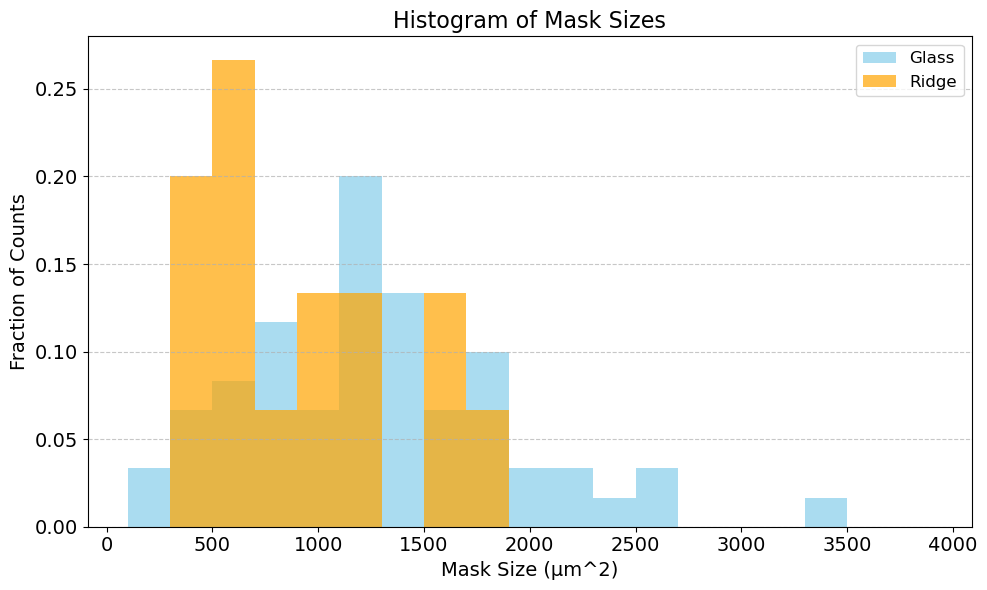

In [161]:
def plot_combined_mask_sizes_histogram(mask_sizes_glass, mask_sizes_ridge):
    """
    Plot combined histograms of mask sizes for glass and ridge data.

    Parameters:
    - mask_sizes_glass: List or list of lists of mask sizes for glass.
    - mask_sizes_ridge: List or list of lists of mask sizes for ridge.
    """
    # Flatten the list of mask sizes for glass and ridge
    if isinstance(mask_sizes_glass[0], list):  # Check if it's a list of lists
        all_mask_sizes_glass = [size for sizes in mask_sizes_glass for size in sizes]
    else:
        all_mask_sizes_glass = mask_sizes_glass  # Use directly if it's already a flat list
    
    if isinstance(mask_sizes_ridge[0], list):  # Check if it's a list of lists
        all_mask_sizes_ridge = [size for sizes in mask_sizes_ridge for size in sizes]
    else:
        all_mask_sizes_ridge = mask_sizes_ridge  # Use directly if it's already a flat list

    # Check if there are mask sizes to plot
    if not all_mask_sizes_glass and not all_mask_sizes_ridge:
        print("No mask sizes to plot for either dataset.")
        return

    # Define bins
    bins = np.arange(100, 4000, 200)

    # Normalize counts to convert y-axis to fractions
    glass_hist, _ = np.histogram(all_mask_sizes_glass, bins=bins)
    ridge_hist, _ = np.histogram(all_mask_sizes_ridge, bins=bins)

    # Calculate fractions
    glass_fractions = glass_hist / glass_hist.sum() if glass_hist.sum() > 0 else np.zeros_like(glass_hist)
    ridge_fractions = ridge_hist / ridge_hist.sum() if ridge_hist.sum() > 0 else np.zeros_like(ridge_hist)

    # Plot the histograms
    plt.figure(figsize=(10, 6))
    plt.bar(bins[:-1], glass_fractions, width=np.diff(bins), align='edge', color='skyblue', alpha=0.7, label='Glass')
    plt.bar(bins[:-1], ridge_fractions, width=np.diff(bins), align='edge', color='orange', alpha=0.7, label='Ridge')

    # Add labels and legend
    plt.title("Histogram of Mask Sizes", fontsize=16)
    plt.xlabel("Mask Size (µm^2)", fontsize=14)
    plt.ylabel("Fraction of Counts", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Increase tick sizes for x and y axes
    plt.tick_params(axis='both', which='major', labelsize=14)

    plt.tight_layout()

    # Show the plot
    plt.show()


plot_combined_mask_sizes_histogram(mask_sizes_glass, mask_sizes_ridge)


### Normalized number of tracks for Glass vs Ridge

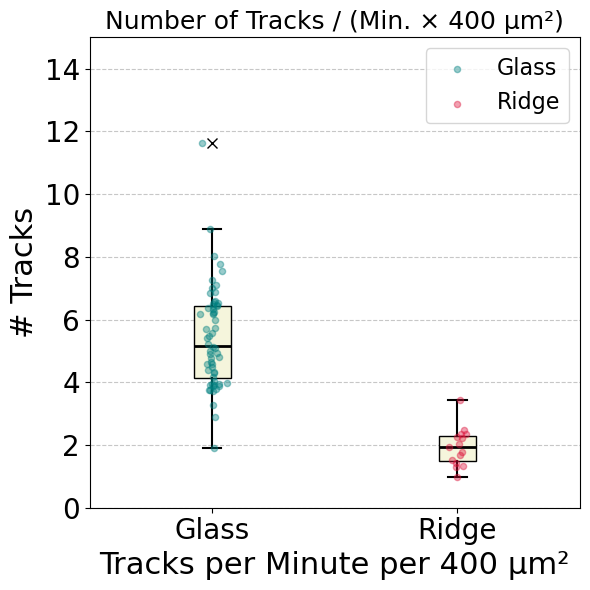

In [163]:
def plot_tracks_per_duration_mask_boxplot_with_scatter(n_tracks_glass, movie_durations_glass, mask_sizes_glass,
                                                      n_tracks_ridge, movie_durations_ridge, mask_sizes_ridge):
    """
    Plot boxplots for the metric:
    Number of Tracks * 100 / (Duration * Mask Size) for Glass and Ridge data with scatter points,
    where points are randomly spread away from the center line.

    Parameters:
    - n_tracks_glass: List of number of tracks for glass.
    - movie_durations_glass: List of movie durations for glass.
    - mask_sizes_glass: List of mask sizes for glass.
    - n_tracks_ridge: List of number of tracks for ridge.
    - movie_durations_ridge: List of movie durations for ridge.
    - mask_sizes_ridge: List of mask sizes for ridge.
    """
    
    # Compute the metric for glass and ridge
    metric_glass = [n * 60 * 400 / (d * m) for n, d, m in zip(n_tracks_glass, movie_durations_glass, mask_sizes_glass)]
    metric_ridge = [n * 60 * 400 / (d * m) for n, d, m in zip(n_tracks_ridge, movie_durations_ridge, mask_sizes_ridge)]
    
    # Combine the data for plotting
    data_glass = np.array(metric_glass)
    data_ridge = np.array(metric_ridge)
    
    # Combine data for boxplot
    data = [data_glass, data_ridge]
    labels = ["Glass", "Ridge"]
    
    # Create the boxplot
    plt.figure(figsize=(6, 6))
    
    # Plot boxplot with light blue and light crimson colors for Glass and Ridge respectively
    plt.boxplot(data, vert=True, patch_artist=True, labels=labels, 
                boxprops=dict(facecolor="beige", color="black"),  # Glass in light blue
                whiskerprops=dict(color="black", linewidth=1.5),
                capprops=dict(color="black", linewidth=1.5),
                flierprops=dict(markerfacecolor='black', marker='x', markersize=7),
                medianprops=dict(color="black", linewidth=2))
    
    # Scatter plot for individual points with jitter
    jitter_strength = 0.02  # Adjust this to control how much spread you want
    
    # Align scatter points correctly with jitter
    glass_x_positions = np.full(len(data_glass), 0) + np.random.normal(0, jitter_strength, len(data_glass))  # Align with Glass (x=0)
    ridge_x_positions = np.full(len(data_ridge), 1) + np.random.normal(0, jitter_strength, len(data_ridge))  # Align with Ridge (x=1)
    
    # Scatter plot
    plt.scatter(glass_x_positions+1, data_glass, 20, color='teal', alpha=0.4, label='Glass', zorder=3)
    plt.scatter(ridge_x_positions+1, data_ridge, 20, color='crimson', alpha=0.4, label='Ridge', zorder=3)

    # Customize labels and ticks
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title("Number of Tracks / (Min. × 400 µm²)", fontsize=18)
    plt.xlabel("Tracks per Minute per 400 µm²", fontsize=22)
    plt.ylabel("# Tracks", fontsize=22)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim([0,15])
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)

    # Add legend and adjust layout
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_tracks_per_duration_mask_boxplot_with_scatter(n_tracks_glass, movie_durations_glass, mask_sizes_glass,
                                                  n_tracks_ridge, movie_durations_ridge, mask_sizes_ridge)


### Raw number of tracks

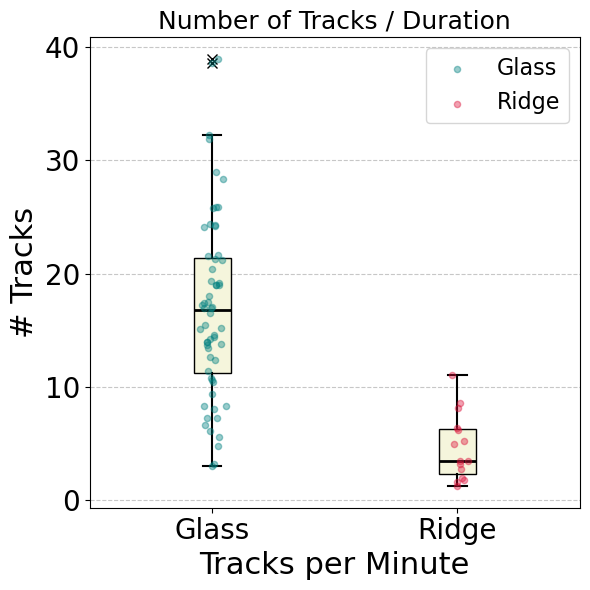

In [164]:
def plot_tracks_per_duration_mask_boxplot_with_scatter(n_tracks_glass, movie_durations_glass, mask_sizes_glass,
                                                      n_tracks_ridge, movie_durations_ridge, mask_sizes_ridge):
    """
    Plot boxplots for the metric:
    Number of Tracks * 100 / Duration for Glass and Ridge data with scatter points,
    where points are randomly spread away from the center line.

    Parameters:
    - n_tracks_glass: List of number of tracks for glass.
    - movie_durations_glass: List of movie durations for glass.
    - mask_sizes_glass: List of mask sizes for glass (not used in calculation).
    - n_tracks_ridge: List of number of tracks for ridge.
    - movie_durations_ridge: List of movie durations for ridge.
    - mask_sizes_ridge: List of mask sizes for ridge (not used in calculation).
    """
    
    # Compute the metric for glass and ridge without dividing by mask size
    metric_glass = [n * 60 / d for n, d in zip(n_tracks_glass, movie_durations_glass)]
    metric_ridge = [n * 60/ d for n, d in zip(n_tracks_ridge, movie_durations_ridge)]
    
    # Combine the data for plotting
    data_glass = np.array(metric_glass)
    data_ridge = np.array(metric_ridge)
    
    # Combine data for boxplot
    data = [data_glass, data_ridge]
    labels = ["Glass", "Ridge"]
    
    # Create the boxplot
    plt.figure(figsize=(6, 6))
    
    # Plot boxplot with light beige for Glass and light crimson for Ridge respectively
    plt.boxplot(data, vert=True, patch_artist=True, labels=labels, 
                boxprops=dict(facecolor="beige", color="black"),  # Glass in beige
                whiskerprops=dict(color="black", linewidth=1.5),
                capprops=dict(color="black", linewidth=1.5),
                flierprops=dict(markerfacecolor='black', marker='x', markersize=7),
                medianprops=dict(color="black", linewidth=2))
    
    # Scatter plot for individual points with jitter
    jitter_strength = 0.02  # Adjust this to control how much spread you want
    
    # Align scatter points correctly with jitter
    glass_x_positions = np.full(len(data_glass), 0) + np.random.normal(0, jitter_strength, len(data_glass))  # Align with Glass (x=0)
    ridge_x_positions = np.full(len(data_ridge), 1) + np.random.normal(0, jitter_strength, len(data_ridge))  # Align with Ridge (x=1)
    
    # Scatter plot
    plt.scatter(glass_x_positions+1, data_glass, 20, color='teal', alpha=0.4, label='Glass', zorder=3)
    plt.scatter(ridge_x_positions+1, data_ridge, 20, color='crimson', alpha=0.4, label='Ridge', zorder=3)

    # Customize labels and ticks
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title("Number of Tracks / Duration", fontsize=18)
    plt.xlabel("Tracks per Minute", fontsize=22)
    plt.ylabel("# Tracks", fontsize=22)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # plt.ylim([0, 40])
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)

    # Add legend and adjust layout
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_tracks_per_duration_mask_boxplot_with_scatter(n_tracks_glass, movie_durations_glass, mask_sizes_glass,
                                                  n_tracks_ridge, movie_durations_ridge, mask_sizes_ridge)


### Movie Duration

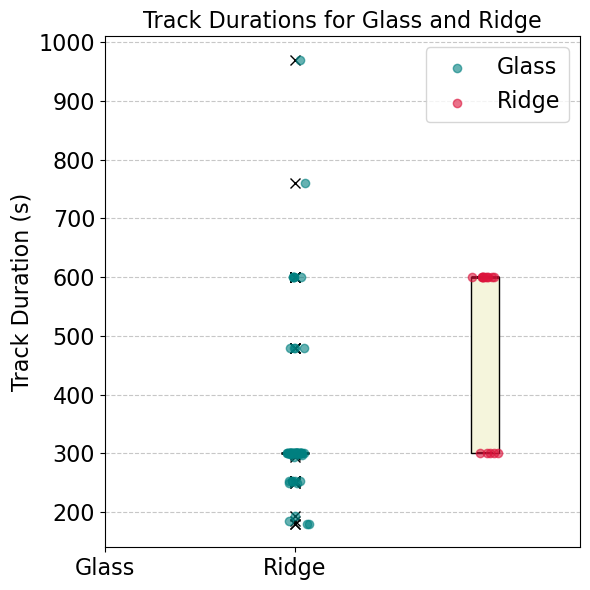

In [165]:
def plot_track_durations_boxplot_with_scatter(track_durations_glass, track_durations_ridge):
    """
    Plot boxplots for the raw track durations for Glass and Ridge data with scatter points, 
    where points are randomly spread away from the center line.

    Parameters:
    - track_durations_glass: List of track durations for glass.
    - track_durations_ridge: List of track durations for ridge.
    """
    # Combine the data and labels for plotting
    data = [track_durations_glass, track_durations_ridge]
    labels = ["Glass", "Ridge"]
    
    # Create the boxplot
    plt.figure(figsize=(6, 6))
    
    # Boxplot for Glass and Ridge
    plt.boxplot(data, vert=True, patch_artist=True, labels=labels, 
                boxprops=dict(facecolor="beige", color="black"),  # Glass in beige
                whiskerprops=dict(color="black", linewidth=1.5),
                capprops=dict(color="black", linewidth=1.5),
                flierprops=dict(markerfacecolor='black', marker='x', markersize=7),
                medianprops=dict(color="black", linewidth=2))

    # Add random jitter to the x-coordinates for scatter points
    jitter_strength = 0.03  # Adjust this to control how much spread you want
    glass_x_positions = 1+np.random.normal(0, jitter_strength, len(track_durations_glass))
    ridge_x_positions = 1+np.random.normal(1, jitter_strength, len(track_durations_ridge))
    
    # Scatter plot for individual points with jitter
    plt.scatter(glass_x_positions, track_durations_glass, color='teal', alpha=0.6, label='Glass', zorder=3)
    plt.scatter(ridge_x_positions, track_durations_ridge, color='crimson', alpha=0.6, label='Ridge', zorder=3)

    # Customize labels and ticks
    plt.xticks(ticks=range(len(labels)), labels=labels, fontsize=16)
    plt.yticks(fontsize=16)
    plt.title("Track Durations for Glass and Ridge", fontsize=16)
    plt.ylabel("Track Duration (s)", fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add legend and adjust layout
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_track_durations_boxplot_with_scatter(movie_durations_glass, movie_durations_ridge)


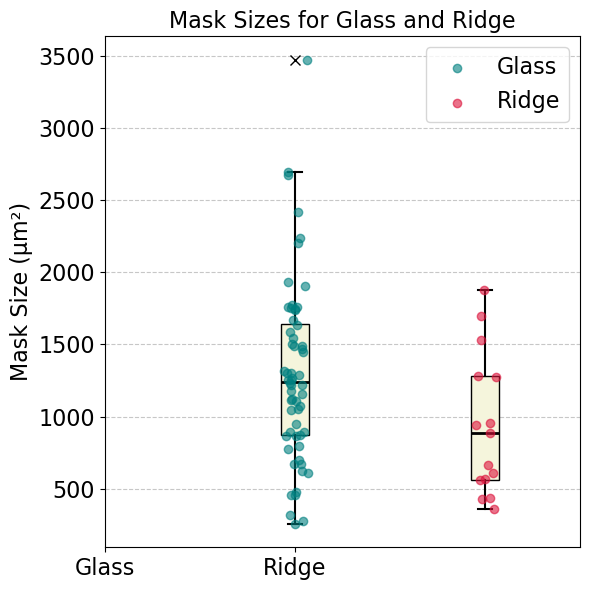

In [166]:
def plot_mask_sizes_boxplot_with_scatter(mask_sizes_glass, mask_sizes_ridge):
    """
    Plot boxplots for the mask sizes for Glass and Ridge data with scatter points, 
    where points are randomly spread away from the center line.

    Parameters:
    - mask_sizes_glass: List of mask sizes for glass.
    - mask_sizes_ridge: List of mask sizes for ridge.
    """
    # Combine the data and labels for plotting
    data = [mask_sizes_glass, mask_sizes_ridge]
    labels = ["Glass", "Ridge"]
    
    # Create the boxplot
    plt.figure(figsize=(6, 6))
    
    # Boxplot for Glass and Ridge
    plt.boxplot(data, vert=True, patch_artist=True, labels=labels, 
                boxprops=dict(facecolor="beige", color="black"),  # Glass in beige
                whiskerprops=dict(color="black", linewidth=1.5),
                capprops=dict(color="black", linewidth=1.5),
                flierprops=dict(markerfacecolor='black', marker='x', markersize=7),
                medianprops=dict(color="black", linewidth=2))

    # Add random jitter to the x-coordinates for scatter points
    jitter_strength = 0.03  # Adjust this to control how much spread you want
    glass_x_positions = np.random.normal(0, jitter_strength, len(mask_sizes_glass))
    ridge_x_positions = np.random.normal(1, jitter_strength, len(mask_sizes_ridge))
    
    # Scatter plot for individual points with jitter
    plt.scatter(glass_x_positions+1, mask_sizes_glass, color='teal', alpha=0.6, label='Glass', zorder=3)
    plt.scatter(ridge_x_positions+1, mask_sizes_ridge, color='crimson', alpha=0.6, label='Ridge', zorder=3)

    # Customize labels and ticks
    plt.xticks(ticks=range(len(labels)), labels=labels, fontsize=16)
    plt.yticks(fontsize=16)
    plt.title("Mask Sizes for Glass and Ridge", fontsize=16)
    plt.ylabel("Mask Size (µm²)", fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add legend and adjust layout
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_mask_sizes_boxplot_with_scatter(mask_sizes_glass, mask_sizes_ridge)


## DIV wise divisions

In [5]:
def analyze_all_divs(main_folder, sheet_path, sheet_name, resolution_range, frame_interval_range):
    """
    Analyze all level-1 folders corresponding to different DIV values, and categorize results into
    Early, Middle, and Late stage based on the DIV values.

    Parameters:
    - main_folder (str): Path to the main folder containing level-1 subfolders.
    - sheet_path (str): Path to the Excel sheet containing imaging details.
    - sheet_name (str): The name of the sheet in the Excel file.
    - resolution_range (tuple): Minimum and maximum allowed resolution values (e.g., (2.6, 2.9)).
    - frame_interval_range (tuple): Minimum and maximum allowed frame interval values (e.g., (1.8, 2.2)).

    Returns:
    - tuple: A tuple of lists:
        1. early_stage (dict): Data for the early stage (DIV 2, 3, 4, 5).
        2. middle_stage (dict): Data for the middle stage (DIV 7, 8, 10, 11, 12).
        3. late_stage (dict): Data for the late stage (DIV 14, 16, 17, 21, 23). Only if `sheet_name` is not 'ridges'.
    """
    # Initialize dictionaries for each stage
    early_stage = {
        "mask_sizes": [],
        "n_tracks": [],
        "movie_durations": []
    }
    
    middle_stage = {
        "mask_sizes": [],
        "n_tracks": [],
        "movie_durations": []
    }
    
    late_stage = {
        "mask_sizes": [],
        "n_tracks": [],
        "movie_durations": []
    }

    # Flag to print when criteria is satisfied
    criteria_flag = False

    # Extract all DIV-level folders
    level_1_folders = [folder for folder in os.listdir(main_folder) if folder.startswith("div")]

    for div_folder in level_1_folders:
        try:
            # Extract DIV value from the folder name (e.g., "div2" -> 2)
            div_value = int(div_folder[3:])
            
            # Call the analysis function for the specific DIV
            masks, tracks, durations = check_level_2_subfolders_by_div_and_params(
                main_folder, sheet_path, div_value, sheet_name, resolution_range, frame_interval_range
            )

            # Categorize by stage
            if div_value in [2, 3, 4, 5]:
                # Early Stage
                early_stage["mask_sizes"].extend(masks)
                early_stage["n_tracks"].extend(tracks)
                early_stage["movie_durations"].extend(durations)
            elif div_value in [7, 8, 10, 11, 12]:
                # Middle Stage
                middle_stage["mask_sizes"].extend(masks)
                middle_stage["n_tracks"].extend(tracks)
                middle_stage["movie_durations"].extend(durations)
            elif div_value in [14, 16, 17, 21, 23]:
                # Late Stage
                late_stage["mask_sizes"].extend(masks)
                late_stage["n_tracks"].extend(tracks)
                late_stage["movie_durations"].extend(durations)

        except ValueError as e:
            print(f"Skipping folder '{div_folder}': {e}")
        except Exception as e:
            print(f"Error processing folder '{div_folder}': {e}")

    if sheet_name == 'ridges':
        # Combine only early and middle stage for ridges
        return early_stage, middle_stage
    else:
        # Combine early, middle, and late stages for glass
        return early_stage, middle_stage, late_stage


In [6]:
# Example usage
main_folder = r'E:\Spandan\2D_Neurons_Paper\Glass'
sheet_path = r'E:\Spandan\Kate\NEURON MOVIES\tifNotes.xlsx'
resolution_range = (2.6, 2.9)
frame_interval_range = (1.8, 2.2)

# Call the analyze_all_divs function to get the results categorized by stage
early_stage, middle_stage, late_stage = analyze_all_divs(main_folder, sheet_path, 'glass', resolution_range, frame_interval_range)

# Access results for each stage
mask_sizes_early_glass = early_stage['mask_sizes']
n_tracks_early_glass = early_stage['n_tracks']
movie_durations_early_glass = early_stage['movie_durations']

mask_sizes_middle_glass = middle_stage['mask_sizes']
n_tracks_middle_glass = middle_stage['n_tracks']
movie_durations_middle_glass = middle_stage['movie_durations']

mask_sizes_late_glass = late_stage['mask_sizes']
n_tracks_late_glass = late_stage['n_tracks']
movie_durations_late_glass = late_stage['movie_durations']


Analyzing Level-2 Subfolder: control_div10_glass_2019_04_22_NewPdl_GFP RFP_5 5_488_timelapse1
Criteria Met
Movie duration added: 300.0(s)
Number of tracks added: 67
Mask size added: 1156.791091268505
Analyzing Level-2 Subfolder: control_div10_glass_2021_04_12_MAX_6well1_div10_timelapse3_100x
Criteria Not Met
Analyzing Level-2 Subfolder: control_div10_glass_2021_12_06_dish2_control_neuron1_media
Criteria Met
Movie duration added: 250.0(s)
Number of tracks added: 108
Mask size added: 2414.9277610012687
Analyzing Level-2 Subfolder: control_div10_glass_2021_12_06_dish2_control_neuron2_media
Criteria Met
Movie duration added: 254.0(s)
Number of tracks added: 120
Mask size added: 3472.835634407588
Analyzing Level-2 Subfolder: control_div10_glass_2021_12_06_dish2_control_neuron3_media
Criteria Met
Movie duration added: 254.0(s)
Number of tracks added: 64
Mask size added: 1499.7072045887453
Analyzing Level-2 Subfolder: control_div10_glass_2021_12_06_dish2_control_neuron4_media
Criteria Met
Mov

### The highest no. tracks/(duration*area) is for the movie (flat, Late): 
'E:\Spandan\2D_Neurons_Paper\Glass\div17\control_2019_02_11_Cort_DIV17_plate1_timelapse2'

In [7]:
# Example usage for Ridges data
main_folder = r'E:\Spandan\2D_Neurons_Paper\Ridges'
sheet_path = r'E:\Spandan\Kate\NEURON MOVIES\tifNotes.xlsx'
resolution_range = (2.6, 2.9)
frame_interval_range = (1.9, 2.1)

# Call the analyze_all_divs function to get the results categorized by stage
early_stage, middle_stage = analyze_all_divs(main_folder, sheet_path, 'ridges', resolution_range, frame_interval_range)

# Access results for each stage
mask_sizes_early_ridge = early_stage['mask_sizes']
n_tracks_early_ridge = early_stage['n_tracks']
movie_durations_early_ridge = early_stage['movie_durations']

mask_sizes_middle_ridge = middle_stage['mask_sizes']
n_tracks_middle_ridge = middle_stage['n_tracks']
movie_durations_middle_ridge = middle_stage['movie_durations']


Analyzing Level-2 Subfolder: ridges_19_01_21_div2cortex_B1_timelapse2
Criteria Met
Movie duration added: 600.102(s)
Number of tracks added: 16
Mask size added: 663.0229915897011
Analyzing Level-2 Subfolder: ridges_19_01_21_div2cortex_B1_timelapse3
Criteria Met
Movie duration added: 300.1125(s)
Number of tracks added: 16
Mask size added: 566.2133405503135
Analyzing Level-2 Subfolder: ridges_19_01_21_div2cortex_B1_timelapse5
Criteria Met
Movie duration added: 300.18899999999996(s)
Number of tracks added: 17
Mask size added: 952.4151612964646
Analyzing Level-2 Subfolder: ridges_19_01_21_div2cortex_B1_timelapse6
Criteria Met
Movie duration added: 600.105(s)
Number of tracks added: 19
Mask size added: 431.30189914201037
Analyzing Level-2 Subfolder: ridges_19_02_11_C2_ridges_timelapse1
Criteria Met
Movie duration added: 599.946(s)
Number of tracks added: 49
Mask size added: 1276.7987711379467
Analyzing Level-2 Subfolder: ridges_19_02_11_C2_ridges_timelapse4a
Criteria Met
Movie duration added

### Mask-size

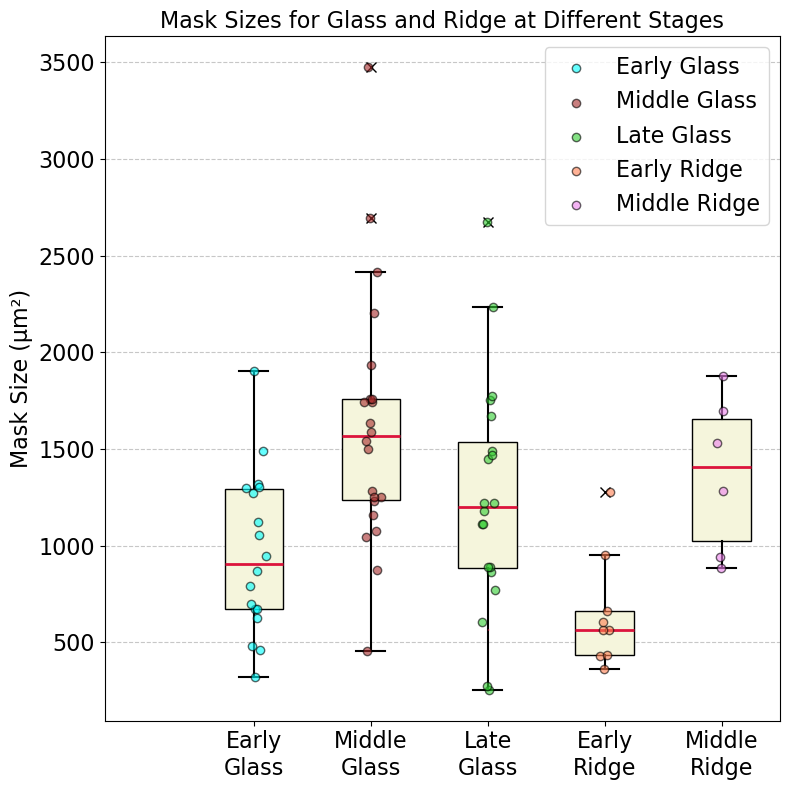

In [172]:
def plot_mask_sizes_boxplot_with_scatter(early_stage_glass, middle_stage_glass, late_stage_glass,
                                         early_stage_ridge, middle_stage_ridge):
    """
    Plot boxplots for the mask sizes for Glass and Ridge data with scatter points,
    where points are randomly spread away from the center line, categorized by stage.
    Adds a red line indicating the median for each category.

    Parameters:
    - early_stage_glass, middle_stage_glass, late_stage_glass: List of mask sizes for Glass at different stages.
    - early_stage_ridge, middle_stage_ridge, late_stage_ridge: List of mask sizes for Ridge at different stages.
    """
    # Combine the data and labels for plotting
    data = [early_stage_glass, middle_stage_glass, late_stage_glass,
            early_stage_ridge, middle_stage_ridge]
    labels = ["Early Glass", "Middle Glass", "Late Glass", "Early Ridge", "Middle Ridge"]
    
    # Create the boxplot
    plt.figure(figsize=(8, 8))

    # Boxplot for each category
    plt.boxplot(data, vert=True, patch_artist=True, labels=labels,
                boxprops=dict(facecolor="beige", color="black"),  # Glass in beige
                whiskerprops=dict(color="black", linewidth=1.5),
                capprops=dict(color="black", linewidth=1.5),
                flierprops=dict(markerfacecolor='black', marker='x', markersize=7),
                medianprops=dict(color="crimson", linewidth=2))

    # Add random jitter to the x-coordinates for scatter points
    jitter_strength = 0.03  # Adjust this to control how much spread you want
    glass_early_x = np.random.normal(0, jitter_strength, len(early_stage_glass))
    glass_middle_x = np.random.normal(1, jitter_strength, len(middle_stage_glass))
    glass_late_x = np.random.normal(2, jitter_strength, len(late_stage_glass))
    
    ridge_early_x = np.random.normal(3, jitter_strength, len(early_stage_ridge))
    ridge_middle_x = np.random.normal(4, jitter_strength, len(middle_stage_ridge))
    
    # Scatter plot for individual points with deeper colors for scatter points
    plt.scatter(glass_early_x+1, early_stage_glass, color='aqua', alpha=0.6, label='Early Glass', edgecolors='black', zorder=3)
    plt.scatter(glass_middle_x+1, middle_stage_glass, color='brown', alpha=0.6, label='Middle Glass', edgecolors='black', zorder=3)
    plt.scatter(glass_late_x+1, late_stage_glass, color='limegreen', alpha=0.6, label='Late Glass', edgecolors='black', zorder=3)
    
    plt.scatter(ridge_early_x+1, early_stage_ridge, color='coral', alpha=0.6, label='Early Ridge', edgecolors='black', zorder=3)
    plt.scatter(ridge_middle_x+1, middle_stage_ridge, color='violet', alpha=0.6, label='Middle Ridge', edgecolors='black', zorder=3)

    # Add median lines for each group in red
    for i, group in enumerate(data):
        median_value = np.median(group)
        # Make the line shorter by adjusting the x-coordinates (i.e., reducing the distance between points)
        plt.plot([i, i], [median_value - 0.1, median_value + 0.1], color='crimson', ls='--', linewidth=1, zorder=4)

    # Customize labels and ticks
    # Shift x labels by one step to the right by adjusting xticks
    plt.xticks(ticks=range(1, len(labels) + 1), labels=[label.replace(" ", "\n") for label in labels], fontsize=16)
    plt.yticks(fontsize=16)
    plt.title("Mask Sizes for Glass and Ridge at Different Stages", fontsize=16)
    plt.ylabel("Mask Size (µm²)", fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add legend and adjust layout
    plt.legend(fontsize=16)
    plt.tight_layout()

    plt.savefig('E:\\Spandan\\2D_Neurons_Paper\\mask_size_boxplot.svg', dpi=600)
    plt.show()

# Example usage with the new stage-separated data
plot_mask_sizes_boxplot_with_scatter(mask_sizes_early_glass, mask_sizes_middle_glass, mask_sizes_late_glass,
                                     mask_sizes_early_ridge, mask_sizes_middle_ridge)


### Number of tracks/ Duration

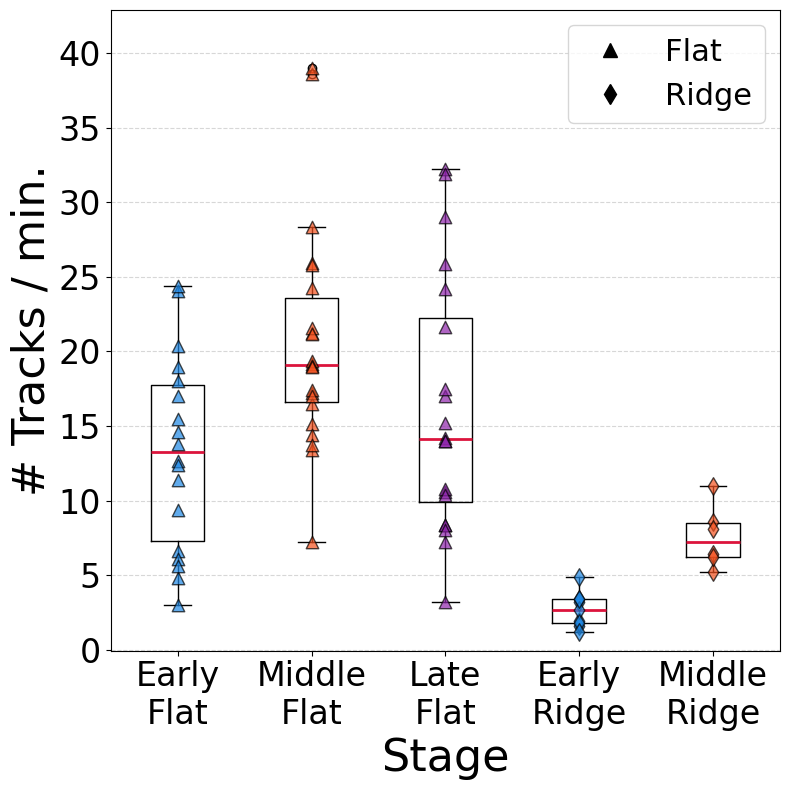

In [31]:
def plot_n_tracks_boxplot(mask_sizes_early_glass, n_tracks_early_glass, movie_durations_early_glass,
                          mask_sizes_middle_glass, n_tracks_middle_glass, movie_durations_middle_glass,   
                          mask_sizes_late_glass, n_tracks_late_glass, movie_durations_late_glass,
                          mask_sizes_early_ridge, n_tracks_early_ridge, movie_durations_early_ridge,
                          mask_sizes_middle_ridge, n_tracks_middle_ridge, movie_durations_middle_ridge):
    
    # Compute number of tracks per minute (not normalized by area)
    normalized_early_glass = [n * 60 / d for n, d in zip(n_tracks_early_glass, movie_durations_early_glass)]
    normalized_middle_glass = [n * 60 / d for n, d in zip(n_tracks_middle_glass, movie_durations_middle_glass)]
    normalized_late_glass = [n * 60 / d for n, d in zip(n_tracks_late_glass, movie_durations_late_glass)]
    normalized_early_ridge = [n * 60 / d for n, d in zip(n_tracks_early_ridge, movie_durations_early_ridge)]
    normalized_middle_ridge = [n * 60 / d for n, d in zip(n_tracks_middle_ridge, movie_durations_middle_ridge)]

    # Combine data and labels
    data = [normalized_early_glass, normalized_middle_glass, normalized_late_glass,
            normalized_early_ridge, normalized_middle_ridge]
    
    labels = ["Early\nFlat", "Middle\nFlat", "Late\nFlat", "Early\nRidge", "Middle\nRidge"]

    # Define group-specific colors and markers
    group_colors = ['#1E88E5', '#F4511E', '#8E24AA', '#1E88E5', '#F4511E']
    group_markers = ['^', '^', '^', 'd', 'd']

    # Create boxplot
    plt.figure(figsize=(8, 8))
    box = plt.boxplot(data, patch_artist=False, medianprops=dict(color="crimson", linewidth=2),
                      widths=0.4, vert=True, positions=np.arange(1, len(labels) + 1))

    plt.ylim([-0.05, max([max(g) for g in data]) * 1.1])

    # Draw scatter points
    for i, (group_data, color, marker) in enumerate(zip(data, group_colors, group_markers)):
        jittered_x = np.random.normal(i + 1, 0.00, size=len(group_data))
        plt.scatter(jittered_x, group_data, s=80, color=color, alpha=0.7,
                    marker=marker, edgecolor='black', linewidth=1, zorder=3)

    # Axis and font formatting
    plt.xticks(ticks=np.arange(1, len(labels) + 1), labels=labels, fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel("Stage", fontsize=32)
    plt.ylabel("# Tracks / min.", fontsize=32)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)

    # Legend with matching markers
    flat_legend = mlines.Line2D([], [], color='black', marker='^', markersize=10, linestyle='None', label='Flat')
    ridge_legend = mlines.Line2D([], [], color='black', marker='d', markersize=10, linestyle='None', label='Ridge')
    plt.legend(handles=[flat_legend, ridge_legend], loc='upper right', fontsize=22)

    # Save and show
    plt.tight_layout()
    plt.savefig('E:\\Spandan\\2D_Neurons_Paper\\n_tracks_boxplot.svg', format='svg', bbox_inches='tight')
    plt.show()


# Example usage with the new stage-separated data
plot_n_tracks_boxplot(mask_sizes_early_glass, n_tracks_early_glass, movie_durations_early_glass,
                      mask_sizes_middle_glass, n_tracks_middle_glass, movie_durations_middle_glass,   
                      mask_sizes_late_glass, n_tracks_late_glass, movie_durations_late_glass,
                      mask_sizes_early_ridge, n_tracks_early_ridge, movie_durations_early_ridge,
                      mask_sizes_middle_ridge, n_tracks_middle_ridge, movie_durations_middle_ridge)

### Normalized number of tracks (by area and duration both)

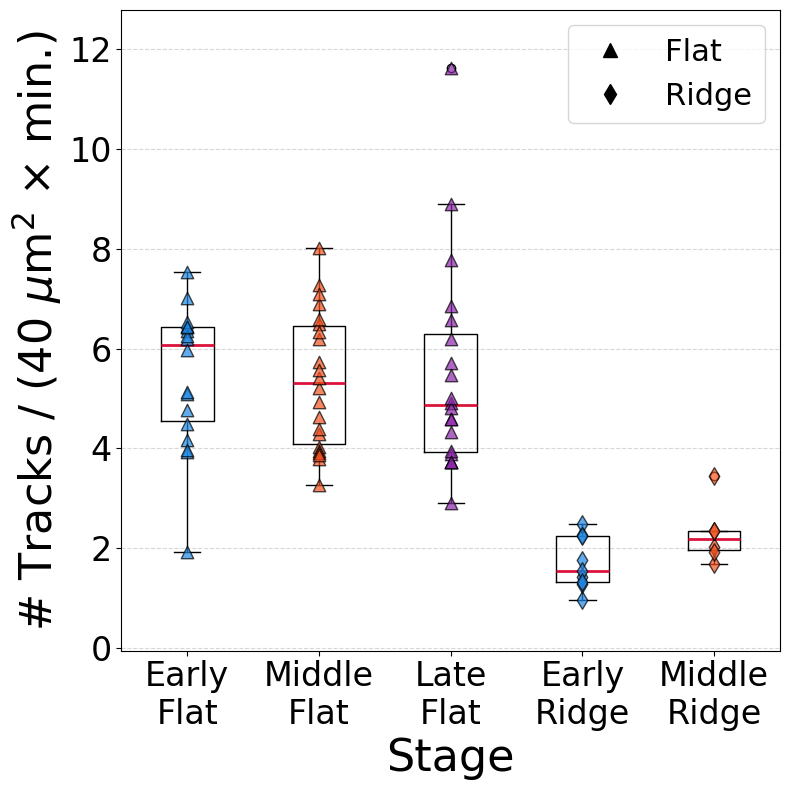

In [71]:
def plot_n_tracks_boxplot(mask_sizes_early_glass, n_tracks_early_glass, movie_durations_early_glass,
                          mask_sizes_middle_glass, n_tracks_middle_glass, movie_durations_middle_glass,   
                          mask_sizes_late_glass, n_tracks_late_glass, movie_durations_late_glass,
                          mask_sizes_early_ridge, n_tracks_early_ridge, movie_durations_early_ridge,
                          mask_sizes_middle_ridge, n_tracks_middle_ridge, movie_durations_middle_ridge):
    
    # Normalize: tracks per min per 400 µm²
    normalize = lambda n, d, m: [i * 60 * 400 / (j * k) for i, j, k in zip(n, d, m)]

    normalized_early_glass   = normalize(n_tracks_early_glass,   movie_durations_early_glass,   mask_sizes_early_glass)
    normalized_middle_glass  = normalize(n_tracks_middle_glass,  movie_durations_middle_glass,  mask_sizes_middle_glass)
    normalized_late_glass    = normalize(n_tracks_late_glass,    movie_durations_late_glass,    mask_sizes_late_glass)
    normalized_early_ridge   = normalize(n_tracks_early_ridge,   movie_durations_early_ridge,   mask_sizes_early_ridge)
    normalized_middle_ridge  = normalize(n_tracks_middle_ridge,  movie_durations_middle_ridge,  mask_sizes_middle_ridge)

    # Data and labels
    data = [normalized_early_glass, normalized_middle_glass, normalized_late_glass,
            normalized_early_ridge, normalized_middle_ridge]
    
    labels = ["Early\nFlat", "Middle\nFlat", "Late\nFlat", "Early\nRidge", "Middle\nRidge"]
    group_colors  = ['#1E88E5', '#F4511E', '#8E24AA', '#1E88E5', '#F4511E']
    group_markers = ['^', '^', '^', 'd', 'd']

    # Plot
    plt.figure(figsize=(8, 8))
    box = plt.boxplot(data, patch_artist=False, medianprops=dict(color='crimson', linewidth=2),
                      widths=0.4, vert=True, positions=np.arange(1, len(labels) + 1))
    
    # Scatter
    for i, (group_data, color, marker) in enumerate(zip(data, group_colors, group_markers)):
        jittered_x = np.random.normal(i + 1, 0.00, size=len(group_data))
        plt.scatter(jittered_x, group_data, s=80, color=color, alpha=0.7, marker=marker,
                    edgecolor='black', linewidth=1, zorder=3)

    # Axis & labels
    plt.xticks(ticks=np.arange(1, len(labels) + 1), labels=labels, fontsize=24)
    plt.yticks(fontsize=24)
    plt.ylim([-0.05, max([max(g) for g in data]) * 1.1])
    plt.xlabel("Stage", fontsize=32)
    plt.ylabel(r"# Tracks / (40 $\mu$m$^2$ × min.)", fontsize=32)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)

    # Legend
    flat_legend  = mlines.Line2D([], [], color='black', marker='^', markersize=10, linestyle='None', label='Flat')
    ridge_legend = mlines.Line2D([], [], color='black', marker='d', markersize=10, linestyle='None', label='Ridge')
    plt.legend(handles=[flat_legend, ridge_legend], loc='upper right', fontsize=22)

    # Save
    plt.tight_layout()
    plt.savefig('E:\\Spandan\\2D_Neurons_Paper\\n_tracks_normalized_boxplot.svg', format='svg', bbox_inches='tight')
    plt.show()



# Example usage with the new stage-separated data
plot_n_tracks_boxplot(mask_sizes_early_glass, n_tracks_early_glass, movie_durations_early_glass,
                      mask_sizes_middle_glass, n_tracks_middle_glass, movie_durations_middle_glass,   
                      mask_sizes_late_glass, n_tracks_late_glass, movie_durations_late_glass,
                      mask_sizes_early_ridge, n_tracks_early_ridge, movie_durations_early_ridge,
                      mask_sizes_middle_ridge, n_tracks_middle_ridge, movie_durations_middle_ridge)


In [73]:
def test_n_tracks_normalized_from_arrays(mask_sizes_early_glass, n_tracks_early_glass, movie_durations_early_glass,
                                         mask_sizes_middle_glass, n_tracks_middle_glass, movie_durations_middle_glass,   
                                         mask_sizes_late_glass, n_tracks_late_glass, movie_durations_late_glass,
                                         mask_sizes_early_ridge, n_tracks_early_ridge, movie_durations_early_ridge,
                                         mask_sizes_middle_ridge, n_tracks_middle_ridge, movie_durations_middle_ridge,
                                         output_path="n_tracks_normalized_stats.csv"):
    """
    Performs statistical tests on normalized track counts (tracks / (400 μm² × min)) using direct input arrays.

    Parameters:
    -----------
    All arrays must be lists or arrays of same length per group (mask_sizes, n_tracks, movie_durations).
    Output is saved to a CSV with optional Tukey results if ANOVA is significant.
    """


    from scipy.stats import shapiro, ttest_ind, mannwhitneyu, f_oneway, kruskal
    from statsmodels.stats.multicomp import pairwise_tukeyhsd

    def normalize(n, d, a):
        return [ni * 60 * 400 / (di * ai) for ni, di, ai in zip(n, d, a)]

    # Normalize input groups
    norm_early_flat   = normalize(n_tracks_early_glass, movie_durations_early_glass, mask_sizes_early_glass)
    norm_middle_flat  = normalize(n_tracks_middle_glass, movie_durations_middle_glass, mask_sizes_middle_glass)
    norm_late_flat    = normalize(n_tracks_late_glass, movie_durations_late_glass, mask_sizes_late_glass)
    norm_early_ridge  = normalize(n_tracks_early_ridge, movie_durations_early_ridge, mask_sizes_early_ridge)
    norm_middle_ridge = normalize(n_tracks_middle_ridge, movie_durations_middle_ridge, mask_sizes_middle_ridge)

    data_groups = [norm_early_flat, norm_middle_flat, norm_late_flat, norm_early_ridge, norm_middle_ridge]
    stage_labels = ["Early\nFlat", "Middle\nFlat", "Late\nFlat", "Early\nRidge", "Middle\nRidge"]

    results = []
    normality_p = []

    # Shapiro–Wilk Normality Test
    for i, vals in enumerate(data_groups):
        stat, p = shapiro(vals)
        normality_p.append(p)
        label = 'Normal' if p >= 0.05 else 'Non-normal'
        results.append({
            'Comparison': f"Shapiro–Wilk: {stage_labels[i]}",
            'Test': 'Shapiro–Wilk',
            'Stat': stat,
            'p-value': p,
            'Significance': label
        })

    any_non_normal = any(p < 0.05 for p in normality_p)

    # Flat vs Ridge (Early and Middle)
    for i, label in zip([0, 1], ['Early', 'Middle']):
        flat = data_groups[i]
        ridge = data_groups[i + 3]
        if any_non_normal:
            stat, p = mannwhitneyu(flat, ridge, alternative='two-sided')
            test_name = "Mann–Whitney U"
        else:
            stat, p = ttest_ind(flat, ridge, equal_var=False)
            test_name = "T-test"
        results.append({
            'Comparison': f"{label} Flat vs Ridge",
            'Test': test_name,
            'Stat': stat,
            'p-value': p,
            'Significance': 'Yes' if p < 0.05 else 'No'
        })

    # Flat intra-group
    flat_vals = data_groups[:3]
    flat_labels = stage_labels[:3]
    flat_concat = np.concatenate(flat_vals)
    flat_names = np.concatenate([[label] * len(vals) for label, vals in zip(flat_labels, flat_vals)])

    if any_non_normal:
        stat, p = kruskal(*flat_vals)
        test_name = "Kruskal–Wallis"
    else:
        stat, p = f_oneway(*flat_vals)
        test_name = "ANOVA"
    results.append({
        'Comparison': 'Flat: Early vs Middle vs Late',
        'Test': test_name,
        'Stat': stat,
        'p-value': p,
        'Significance': 'Yes' if p < 0.05 else 'No'
    })

    if not any_non_normal and p < 0.05:
        tukey = pairwise_tukeyhsd(flat_concat, flat_names, alpha=0.05)
        tukey_df = pd.DataFrame(tukey.summary().data[1:], columns=tukey.summary().data[0])
        tukey_df.insert(0, 'Comparison', 'Tukey HSD (Flat)')
        tukey_df.to_csv(output_path.replace('.csv', '_tukey.csv'), index=False)

    # Ridge intra-group (Early vs Middle)
    ridge_early, ridge_middle = data_groups[3], data_groups[4]
    if any_non_normal:
        stat, p = mannwhitneyu(ridge_early, ridge_middle, alternative='two-sided')
        test_name = "Mann–Whitney U"
    else:
        stat, p = ttest_ind(ridge_early, ridge_middle, equal_var=False)
        test_name = "T-test"
    results.append({
        'Comparison': 'Ridges: Early vs Middle',
        'Test': test_name,
        'Stat': stat,
        'p-value': p,
        'Significance': 'Yes' if p < 0.05 else 'No'
    })

    # Save results
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"\n✅ Statistical results saved to: {output_path}")
    return results_df



test_n_tracks_normalized_from_arrays(
    mask_sizes_early_glass, n_tracks_early_glass, movie_durations_early_glass,
    mask_sizes_middle_glass, n_tracks_middle_glass, movie_durations_middle_glass,   
    mask_sizes_late_glass, n_tracks_late_glass, movie_durations_late_glass,
    mask_sizes_early_ridge, n_tracks_early_ridge, movie_durations_early_ridge,
    mask_sizes_middle_ridge, n_tracks_middle_ridge, movie_durations_middle_ridge,
    output_path=r"E:\Spandan\2D_Neurons_Paper\Combined Plots_glass_vs_ridge\n_tracks_stats.csv")





✅ Statistical results saved to: E:\Spandan\2D_Neurons_Paper\Combined Plots_glass_vs_ridge\n_tracks_stats.csv


,Comparison,Test,Stat,p-value,Significance
0,Shapiro–Wilk: Early\nFlat,Shapiro–Wilk,0.918989,0.124053,Normal
1,Shapiro–Wilk: Middle\nFlat,Shapiro–Wilk,0.951733,0.341708,Normal
2,Shapiro–Wilk: Late\nFlat,Shapiro–Wilk,0.860924,0.008170,Non-normal
3,Shapiro–Wilk: Early\nRidge,Shapiro–Wilk,0.930899,0.489952,Normal
4,Shapiro–Wilk: Middle\nRidge,Shapiro–Wilk,0.859323,0.186855,Normal
5,Early Flat vs Ridge,Mann–Whitney U,159.000000,0.000067,Yes
6,Middle Flat vs Ridge,Mann–Whitney U,131.000000,0.000011,Yes
7,Flat: Early vs Middle vs Late,Kruskal–Wallis,0.796593,0.671463,No
8,Ridges: Early vs Middle,Mann–Whitney U,12.000000,0.087912,No


In [176]:
# Calculate the desired value for each corresponding element in the lists
normalized_late_glass = [(60 * n * 400) / (d * m) for n, d, m in zip(n_tracks_late_glass, movie_durations_late_glass, mask_sizes_late_glass)]

# Find the index of the maximum value
max_value = max(normalized_late_glass)
max_index = normalized_late_glass.index(max_value)

# Print the results
print("Normalized Values:", normalized_late_glass)
print("Maximum Value:", max_value)
print("Index of Maximum Value:", max_index)


Normalized Values: [4.337309834016824, 4.910186528830858, 4.812546582980126, 5.008469186206897, 3.7384558333333335, 3.7384558333333335, 3.8817766747059266, 6.193283357425359, 2.897085578724144, 3.946926286676838, 8.902480067614704, 3.7298720676737167, 7.784569053650572, 5.708221857267188, 5.469145589554675, 11.625119156308854, 6.852963068830061, 6.575876894988336, 4.583648464729723, 4.587109119320595]
Maximum Value: 11.625119156308854
Index of Maximum Value: 15


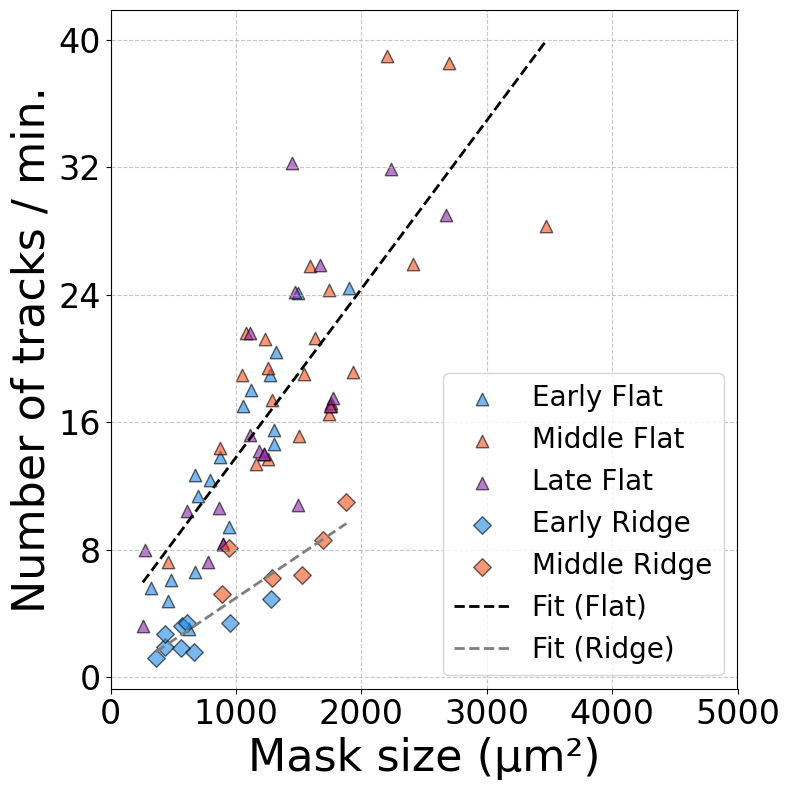

In [74]:
from scipy.stats import linregress

def plot_n_tracks_scatter(mask_sizes_early_glass, n_tracks_early_glass, movie_durations_early_glass,
                          mask_sizes_middle_glass, n_tracks_middle_glass, movie_durations_middle_glass,   
                          mask_sizes_late_glass, n_tracks_late_glass, movie_durations_late_glass,
                          mask_sizes_early_ridge, n_tracks_early_ridge, movie_durations_early_ridge,
                          mask_sizes_middle_ridge, n_tracks_middle_ridge, movie_durations_middle_ridge):
    
    # Normalize track counts per minute
    normalize = lambda n, d: [i * 60 / j for i, j in zip(n, d)]
    
    norm_early_glass   = normalize(n_tracks_early_glass, movie_durations_early_glass)
    norm_middle_glass  = normalize(n_tracks_middle_glass, movie_durations_middle_glass)
    norm_late_glass    = normalize(n_tracks_late_glass, movie_durations_late_glass)
    norm_early_ridge   = normalize(n_tracks_early_ridge, movie_durations_early_ridge)
    norm_middle_ridge  = normalize(n_tracks_middle_ridge, movie_durations_middle_ridge)

    # Colors and markers
    group_colors   = ['#1E88E5', '#F4511E', '#8E24AA']
    flat_markers   = ['^', '^', '^']
    ridge_markers  = ['D', 'D']
    scatter_size   = 80

    # Create scatter plot
    plt.figure(figsize=(8, 8))

    # Plot scatter points
    plt.scatter(mask_sizes_early_glass, norm_early_glass, scatter_size, color=group_colors[0], alpha=0.6, label="Early Flat", 
                edgecolors='black', marker=flat_markers[0])
    plt.scatter(mask_sizes_middle_glass, norm_middle_glass, scatter_size, color=group_colors[1], alpha=0.6, label="Middle Flat", 
                edgecolors='black', marker=flat_markers[1])
    plt.scatter(mask_sizes_late_glass, norm_late_glass, scatter_size, color=group_colors[2], alpha=0.6, label="Late Flat", 
                edgecolors='black', marker=flat_markers[2])

    plt.scatter(mask_sizes_early_ridge, norm_early_ridge, scatter_size, color=group_colors[0], alpha=0.6, label="Early Ridge", 
                edgecolors='black', marker=ridge_markers[0])
    plt.scatter(mask_sizes_middle_ridge, norm_middle_ridge, scatter_size, color=group_colors[1], alpha=0.6, label="Middle Ridge", 
                edgecolors='black', marker=ridge_markers[1])

    # --- Fit and plot regression lines ---
    # Flat
    mask_sizes_flat = np.concatenate([mask_sizes_early_glass, mask_sizes_middle_glass, mask_sizes_late_glass])
    norm_flat       = np.concatenate([norm_early_glass, norm_middle_glass, norm_late_glass])
    slope_f, intercept_f, *_ = linregress(mask_sizes_flat, norm_flat)
    x_flat = np.linspace(min(mask_sizes_flat), max(mask_sizes_flat), 100)
    y_flat = slope_f * x_flat + intercept_f
    plt.plot(x_flat, y_flat, color='black', linestyle='--', linewidth=2, label="Fit (Flat)")

    # Ridge
    mask_sizes_ridge = np.concatenate([mask_sizes_early_ridge, mask_sizes_middle_ridge])
    norm_ridge       = np.concatenate([norm_early_ridge, norm_middle_ridge])
    slope_r, intercept_r, *_ = linregress(mask_sizes_ridge, norm_ridge)
    x_ridge = np.linspace(min(mask_sizes_ridge), max(mask_sizes_ridge), 100)
    y_ridge = slope_r * x_ridge + intercept_r
    plt.plot(x_ridge, y_ridge, color='gray', linestyle='--', linewidth=2, label="Fit (Ridge)")

    # Axes and style
    plt.xlabel("Mask size (μm²)", fontsize=32)
    plt.ylabel("Number of tracks / min.", fontsize=32)
    plt.xlim([0, 4000])
    plt.xticks(np.arange(0, 5400, 1000), fontsize=24)
    plt.yticks(np.arange(0, 46, 8), fontsize=24)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right', fontsize=20)

    # Export and display
    plt.tight_layout()
    plt.savefig('E:\\Spandan\\2D_Neurons_Paper\\scatter_n_tracks_vs_masksize.svg', dpi=600)
    plt.show()


# Example usage
plot_n_tracks_scatter(mask_sizes_early_glass, n_tracks_early_glass, movie_durations_early_glass,
                      mask_sizes_middle_glass, n_tracks_middle_glass, movie_durations_middle_glass,   
                      mask_sizes_late_glass, n_tracks_late_glass, movie_durations_late_glass,
                      mask_sizes_early_ridge, n_tracks_early_ridge, movie_durations_early_ridge,
                      mask_sizes_middle_ridge, n_tracks_middle_ridge, movie_durations_middle_ridge)

### Movie duration

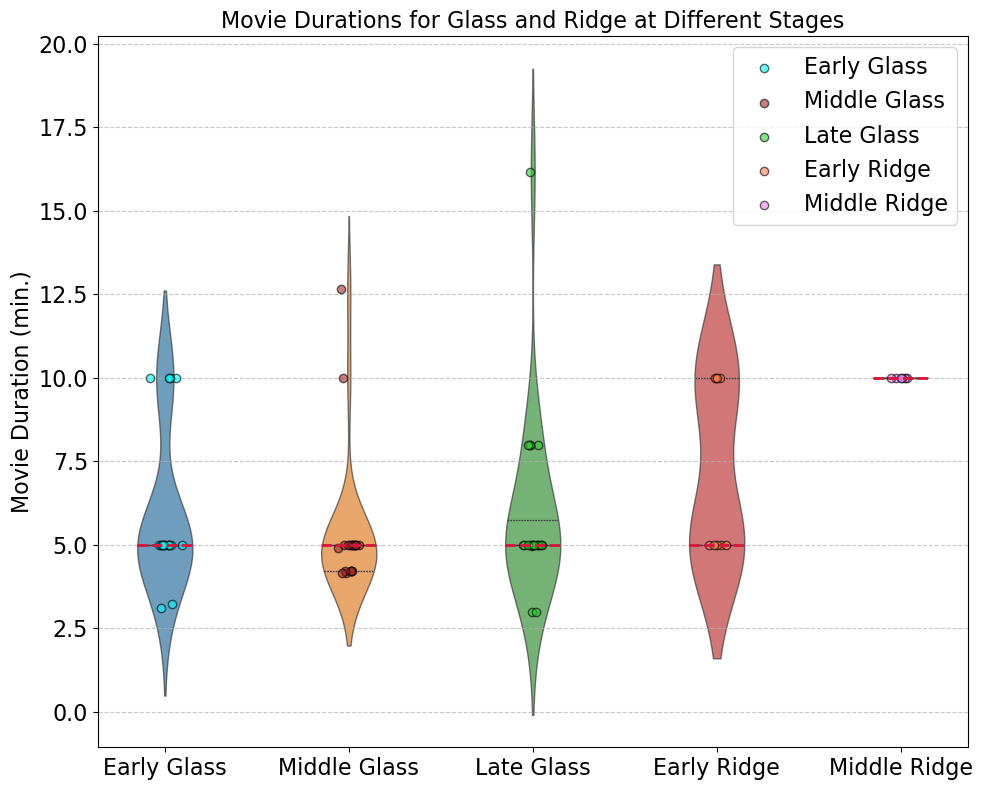

In [191]:
def plot_movie_durations_violin_with_scatter(early_stage_glass, middle_stage_glass, late_stage_glass,
                                             early_stage_ridge, middle_stage_ridge):
    """
    Plot violin plots for the movie durations for Glass and Ridge data with scatter points,
    where points are randomly spread away from the center line, categorized by stage.
    Adds a red line indicating the median for each category.

    Parameters:
    - early_stage_glass, middle_stage_glass, late_stage_glass: List of movie durations for Glass at different stages.
    - early_stage_ridge, middle_stage_ridge, late_stage_ridge: List of movie durations for Ridge at different stages.
    """
    # Convert the movie durations to minutes (by dividing by 60)
    early_stage_glass = np.array(early_stage_glass) / 60
    middle_stage_glass = np.array(middle_stage_glass) / 60
    late_stage_glass = np.array(late_stage_glass) / 60
    early_stage_ridge = np.array(early_stage_ridge) / 60
    middle_stage_ridge = np.array(middle_stage_ridge) / 60
    
    # Combine the data and labels for plotting
    data = [early_stage_glass, middle_stage_glass, late_stage_glass,
            early_stage_ridge, middle_stage_ridge]
    labels = ["Early Glass", "Middle Glass", "Late Glass", "Early Ridge", "Middle Ridge"]
    
    # Create the violin plot with lighter colors for the violin sections
    plt.figure(figsize=(10, 8))
    ax = sns.violinplot(data=data, inner='quart', width=0.3, alpha=0.7, linewidth=1)  # Use lighter palette for violins
    
    # Add random jitter to the x-coordinates for scatter points
    jitter_strength = 0.03  # Adjust this to control how much spread you want
    glass_early_x = np.random.normal(0, jitter_strength, len(early_stage_glass))
    glass_middle_x = np.random.normal(1, jitter_strength, len(middle_stage_glass))
    glass_late_x = np.random.normal(2, jitter_strength, len(late_stage_glass))
    
    ridge_early_x = np.random.normal(3, jitter_strength, len(early_stage_ridge))
    ridge_middle_x = np.random.normal(4, jitter_strength, len(middle_stage_ridge))
    
    # Scatter plot for individual points with deeper colors for scatter points
    plt.scatter(glass_early_x, early_stage_glass, color='aqua', alpha=0.6, label='Early Glass', edgecolors='black', zorder=3)
    plt.scatter(glass_middle_x, middle_stage_glass, color='brown', alpha=0.6, label='Middle Glass', edgecolors='black', zorder=3)
    plt.scatter(glass_late_x, late_stage_glass, color='limegreen', alpha=0.6, label='Late Glass', edgecolors='black', zorder=3)
    
    plt.scatter(ridge_early_x, early_stage_ridge, color='coral', alpha=0.6, label='Early Ridge', edgecolors='black', zorder=3)
    plt.scatter(ridge_middle_x, middle_stage_ridge, color='violet', alpha=0.6, label='Middle Ridge', edgecolors='black', zorder=3)

    # Add median lines for each group in red
    for i, group in enumerate(data):
        median_value = np.median(group)
        plt.plot([i - 0.15, i + 0.15], [median_value, median_value], color='crimson', ls='--', linewidth=2, zorder=4)

    # Customize labels and ticks
    plt.xticks(ticks=range(len(labels)), labels=labels, fontsize=16)
    plt.yticks(fontsize=16)
    plt.title("Movie Durations for Glass and Ridge at Different Stages", fontsize=16)
    plt.ylabel("Movie Duration (min.)", fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add legend and adjust layout
    plt.legend(fontsize=16)
    plt.tight_layout()

    plt.savefig('E:\\Spandan\\2D_Neurons_Paper\\movie_durations.svg', dpi=600)
    plt.show()

# Example usage with the movie durations data
plot_movie_durations_violin_with_scatter(movie_durations_early_glass, movie_durations_middle_glass, movie_durations_late_glass,
                                         movie_durations_early_ridge, movie_durations_middle_ridge)
